In [17]:
import numpy as np
from scipy.optimize import bisect, newton
import matplotlib.pyplot as plt

# Уравнения
def f1(x, a0, a1, a2):
    return a2 * x**2 + a1 * x + a0

def f2(x, a0, a1, a2):
    return np.exp(a2 * x) + a1 * x + a0

# Интервалы коэффициентов
intervals_f1 = {'a2': [1.0, 1.1], 'a1': [-0.1, 0.1], 'a0': [-0.1, 0.1]}
intervals_f2 = {'a2': [1.0, 1.1], 'a1': [1.9, 2.1], 'a0': [1.1, 1.2]}

# Практика

In [14]:
# Метод Монте-Карло
def monte_carlo(func, intervals, n_samples=10000, x_guess=0):
    samples = {
        key: np.random.uniform(low, high, n_samples)
        for key, (low, high) in intervals.items()
    }
    roots = []
    for i in range(n_samples):
        a0, a1, a2 = samples['a0'][i], samples['a1'][i], samples['a2'][i]
        try:
            root = newton(func, x_guess, args=(a0, a1, a2))
            roots.append(root)
        except RuntimeError:
            continue
    return np.array(roots)

roots_f1_mc = monte_carlo(f1, intervals_f1)
roots_f2_mc = monte_carlo(f2, intervals_f2)
print("Метод Монте-Карло")
print(f"Погрешность для f1 : [{min(roots_f1_mc)}, {max(roots_f1_mc)}]")
print(f"Погрешность для f2 : [{min(roots_f2_mc)}, {max(roots_f2_mc)}]")

Метод Монте-Карло
Погрешность для f1 : [-0.3112439773412434, 0.3102571802862363]
Погрешность для f2 : [-0.8538434192153941, -0.7373578649751218]


In [15]:
len(roots_f1_mc)

5059

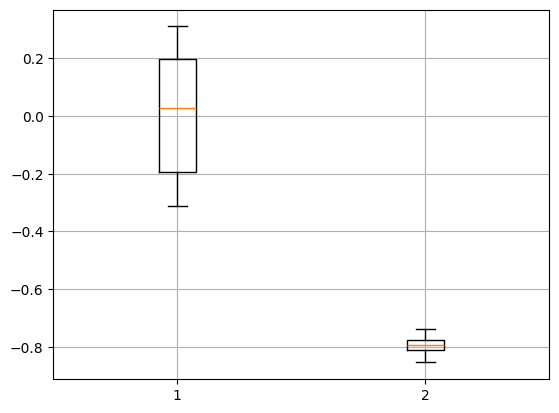

In [18]:
plt.boxplot([roots_f1_mc, roots_f2_mc])
plt.grid()
plt.show()

In [19]:
# Аналитическая оценка величины погрешности корней
def analytical_error(func, intervals, root, delta=1e-7):
    params = {key: (val[0] + val[1]) / 2 for key, val in intervals.items()}  # Средние значения параметров
    param_deltas = {key: (val[1] - val[0]) for key, val in intervals.items()}  # Полуинтервалы

    total_error = 0
    for i, (key, delta_param) in enumerate(param_deltas.items()):
        # Смещаем параметр вверх и вниз
        params_high = params.copy()
        params_low = params.copy()
        params_high[key] += delta
        params_low[key] -= delta

        # Корни для сдвинутых параметров
        root_high = func(root, **params_high)
        root_low = func(root, **params_low)

        # Производная корня по параметру
        derivative = (root_high - root_low) / (2 * delta)
        total_error += abs(derivative) * delta_param

    return total_error

# Метод интервальной бисекции для аналитической оценки
def interval_bisection_for_analytical(func, intervals, x_left, x_right, tol=1e-6, max_iter=100):
    a0, a1, a2 = intervals['a0'], intervals['a1'], intervals['a2']
    for i in range(max_iter):
        x_mid = (x_left + x_right) / 2
        f_mid = func(x_mid, np.mean(a0), np.mean(a1), np.mean(a2))

        if abs(f_mid) < tol or (x_right - x_left) < tol:
            return x_mid
        elif f_mid > 0:
            x_right = x_mid
        else:
            x_left = x_mid

    raise RuntimeError("Бисекция не сошлась за указанное количество итераций.")

# Интервалы коэффициентов
intervals_f1 = {'a0': [-0.1, 0.1], 'a1': [-0.1, 0.1], 'a2': [1.0, 1.1]}
intervals_f2 = {'a0': [1.1, 1.2], 'a1': [1.9, 2.1], 'a2': [1.0, 1.1]}

# Решение уравнений методом бисекции
try:
    root_f1 = interval_bisection_for_analytical(f1, intervals_f1, -10, 10)
    root_f2 = interval_bisection_for_analytical(f2, intervals_f2, -10, 10)

    # Оценка погрешности
    error_f1 = analytical_error(f1, intervals_f1, root_f1)
    error_f2 = analytical_error(f2, intervals_f2, root_f2)

    print(f"f1: Найденный корень = {root_f1:.6f}, аналитическая погрешность = {error_f1:.6f}")
    print(f"f2: Найденный корень = {root_f2:.6f}, аналитическая погрешность = {error_f2:.6f}")

except RuntimeError as e:
    print(f"Ошибка: {e}")

f1: Найденный корень = 0.000000, аналитическая погрешность = 0.200000
f2: Найденный корень = -0.792550, аналитическая погрешность = 0.292994


In [20]:
# Интервальная бисекция
def interval_bisection(func, intervals, x_left, x_right, tol=1e-6, max_iter=100):
    iter_data = []
    a0, a1, a2 = intervals['a0'], intervals['a1'], intervals['a2']
    for i in range(max_iter):
        x_mid = (x_left + x_right) / 2
        f_mid = func(x_mid, np.mean(a0)-0.01, np.mean(a1), np.mean(a2))

        iter_data.append((x_left, x_right))

        if abs(f_mid) < tol or (x_right - x_left) < tol:
            break
        elif f_mid > 0:
            x_right = x_mid
        else:
            x_left = x_mid
    return iter_data

bisection_data_f1 = interval_bisection(f1, intervals_f1, -10, 10)
bisection_data_f2 = interval_bisection(f2, intervals_f2, -10, 10)

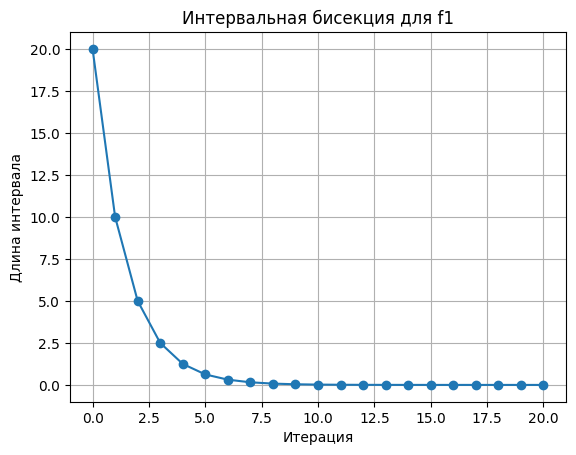

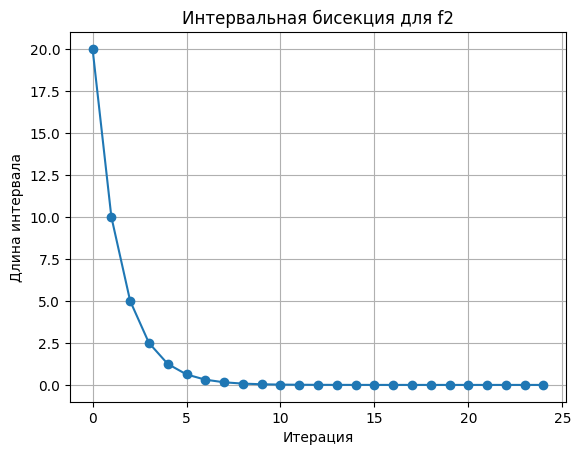

In [21]:
# График изменения интервала
def plot_bisection(data, title):
    lengths = [x_right - x_left for x_left, x_right in data]
    plt.plot(range(len(lengths)), lengths, marker='o')
    plt.xlabel('Итерация')
    plt.ylabel('Длина интервала')
    plt.title(title)
    plt.grid()
    plt.show()

plot_bisection(bisection_data_f1, 'Интервальная бисекция для f1')
plot_bisection(bisection_data_f2, 'Интервальная бисекция для f2')

In [22]:
print(bisection_data_f1)
print(bisection_data_f2)

[(-10, 10), (0.0, 10), (0.0, 5.0), (0.0, 2.5), (0.0, 1.25), (0.0, 0.625), (0.0, 0.3125), (0.0, 0.15625), (0.078125, 0.15625), (0.078125, 0.1171875), (0.078125, 0.09765625), (0.087890625, 0.09765625), (0.0927734375, 0.09765625), (0.09521484375, 0.09765625), (0.096435546875, 0.09765625), (0.0970458984375, 0.09765625), (0.09735107421875, 0.09765625), (0.097503662109375, 0.09765625), (0.0975799560546875, 0.09765625), (0.0975799560546875, 0.09761810302734375), (0.0975799560546875, 0.09759902954101562)]
[(-10, 10), (-10, 0.0), (-5.0, 0.0), (-2.5, 0.0), (-1.25, 0.0), (-1.25, -0.625), (-0.9375, -0.625), (-0.9375, -0.78125), (-0.859375, -0.78125), (-0.8203125, -0.78125), (-0.80078125, -0.78125), (-0.791015625, -0.78125), (-0.791015625, -0.7861328125), (-0.78857421875, -0.7861328125), (-0.78857421875, -0.787353515625), (-0.78857421875, -0.7879638671875), (-0.78857421875, -0.78826904296875), (-0.78857421875, -0.788421630859375), (-0.7884979248046875, -0.788421630859375), (-0.7884979248046875, -0.

# ДЗ

In [2]:
import numpy as np
import warnings
from scipy.optimize import fsolve

# Задаем систему уравнений
def system_equations(vars, a0, a1, a2, b0, b1, b2):
    x, y = vars
    eq1 = a2 * x**2 + a1 * x + a0 - y
    eq2 = np.exp(b2 * y) + b1 * y + b0 - x
    return [eq1, eq2]

# Метод Монте-Карло
def monte_carlo_system(system_func, intervals, num_samples=1000):
    results = []
    a0_range, a1_range, a2_range = intervals['a0'], intervals['a1'], intervals['a2']
    b0_range, b1_range, b2_range = intervals['b0'], intervals['b1'], intervals['b2']

    for _ in range(num_samples):
        # Случайный выбор параметров в заданных диапазонах
        a0 = np.random.uniform(*a0_range)
        a1 = np.random.uniform(*a1_range)
        a2 = np.random.uniform(*a2_range)
        b0 = np.random.uniform(*b0_range)
        b1 = np.random.uniform(*b1_range)
        b2 = np.random.uniform(*b2_range)

        # Решение системы с текущими коэффициентами
        try:
            with warnings.catch_warnings():
              warnings.filterwarnings("ignore", message="The iteration is not making good progress")
              root = fsolve(system_func, [0, 0], args=(a0, a1, a2, b0, b1, b2))
            results.append(root)
        except RuntimeError:
            pass  # Пропускаем неудачные итерации

    return np.array(results)

# Аналитическая оценка погрешности
def analytical_error_system(system_func, intervals, nominal_roots, delta=1e-7):
    param_deltas = {key: (val[1] - val[0]) for key, val in intervals.items()}  # Полуинтервалы
    params = {key: (val[0] + val[1]) / 2 for key, val in intervals.items()}  # Средние значения параметров

    total_errors = np.zeros(2)  # Погрешности для x и y
    for key, delta_param in param_deltas.items():
        params_high = params.copy()
        params_low = params.copy()
        params_high[key] += delta
        params_low[key] -= delta

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="The iteration is not making good progress")
            root_high = fsolve(system_func, nominal_roots, args=tuple(params_high.values()))
            root_low = fsolve(system_func, nominal_roots, args=tuple(params_low.values()))

        derivative = (root_high - root_low) / (2 * delta)
        total_errors += abs(derivative) * delta_param

    return total_errors

# Интервалы коэффициентов
intervals = {
    'a0': [-0.1, 0.1], 'a1': [-0.1, 0.1], 'a2': [1.0, 1.1],
    'b0': [1.1, 1.2], 'b1': [1.9, 2.1], 'b2': [1.0, 1.1]
}

# Номинальные значения параметров (средние значения)
params_nominal = {key: (val[0] + val[1]) / 2 for key, val in intervals.items()}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="The iteration is not making good progress")
    nominal_roots = fsolve(system_equations, [0, 0], args=tuple(params_nominal.values()))

# Решение методом Монте-Карло
monte_carlo_roots = monte_carlo_system(system_equations, intervals, num_samples=1000)

# Аналитическая оценка погрешностей
errors_analytical = analytical_error_system(system_equations, intervals, nominal_roots)

# Вывод результатов
print("Номинальные корни:")
print(f"x = {nominal_roots[0]:.6f}, y = {nominal_roots[1]:.6f}")

print("\nРезультаты метода Монте-Карло:")
mean_roots = np.mean(monte_carlo_roots, axis=0)
std_roots = np.std(monte_carlo_roots, axis=0)
print(f"x (среднее) = {mean_roots[0]:.6f}, y (среднее) = {mean_roots[1]:.6f}")
print(f"x (стандартное отклонение) = {std_roots[0]:.6f}, y (стандартное отклонение) = {std_roots[1]:.6f}")

print("\nАналитическая оценка погрешностей:")
print(f"Δx = {errors_analytical[0]:.6f}, Δy = {errors_analytical[1]:.6f}")

Номинальные корни:
x = 0.187511, y = -0.615634

Результаты метода Монте-Карло:
x (среднее) = 0.187395, y (среднее) = -0.615915
x (стандартное отклонение) = 0.028721, y (стандартное отклонение) = 0.017231

Аналитическая оценка погрешностей:
Δx = 0.000000, Δy = 0.000000
